In [ ]:
from pysr import PySRRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

plt.rcParams['figure.figsize'] = (21, 15)
plt.rcParams['xtick.labelsize'] = 65
plt.rcParams['ytick.labelsize'] = 65
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update({'figure.autolayout': False})
plt.rcParams['axes.linewidth'] = 5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

df = pd.read_excel("Set_only_ratios.xlsx")

for col in df.columns:
    if df[col].dtype == object:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(",", ".", regex=False)
            .pipe(pd.to_numeric, errors='ignore')
        )

target_column = "slowdown"
drop_columns = ["Name", "Sequence", "slowdown"]

# 6. Spalten säubern
def clean_column(col):
    return re.sub(r'\W|^(?=\d)', '_', col)

df.columns = [clean_column(c) for c in df.columns]

X = df[[c for c in df.columns if c not in drop_columns]].values
y = df[target_column].values
feature_names = [c for c in df.columns if c not in drop_columns]

model = PySRRegressor(
    niterations= 800,
    population_size=600,
    maxdepth=7,
    maxsize=10,
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["exp"], 
    elementwise_loss="(x, y) -> (x - y)^2",
    model_selection="best",
    turbo=True,
    deterministic=False,
    parallelism="multithreading",
    procs=6,
    timeout_in_seconds=600,
    verbosity=1,
    update_verbosity=500
)

model.fit(X, y, variable_names=feature_names)

with open("pysr_equations_only_ratios.txt", "w") as f:
    for _, row in model.equations_.iterrows():
        f.write(f"Complexity {row['complexity']}, Loss {row['loss']:.5f}, Score {row['score']:.5f}\n")
        f.write(f"Equation: {row['sympy_format']}\n")
        f.write("-" * 80 + "\n")

y_pred = model.predict(X)

/tmp/ipykernel_646/2375933726.py:25: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  .pipe(pd.to_numeric, errors='ignore')
/tmp/ipykernel_646/2375933726.py:25: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  .pipe(pd.to_numeric, errors='ignore')
/root/miniconda3/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/pysr/sr.py:2860: UserWarning: `numprocs` is specified but will be ignored since `parallelism='multithreading'`
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 8.630e+05
Progress: 265 / 24800 total iterations (1.069%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.254e-01  1.594e+01  y = 2.3376
5           2.647e-01  1.186e-01  y = (0.15317 / Seed_Pur_Pyr) + 1.9743
6           2.607e-01  1.531e-02  y = (1.3301 / exp(Seed_Pur_Pyr)) + 1.7598
7           1.996e-01  2.667e-01  y = ((Seed_AT_GC * 0.042957) / Seed_Pur_Pyr) + 2.0765
8           1.882e-01  5.919e-02  y = exp(exp(Pur_Pyr - exp(Seed_Pur_Pyr))) + 0.92308
9           1.420e-01  2.818e-01  y = ((Seed_AT_GC * (0.254 / AT_GC)) / Seed_Pur_Pyr) + 1.90...
                                      22
───────────────────────────────────────────────────────────────────────────────────────────────────
═══════════════════════════════════════════════════════════

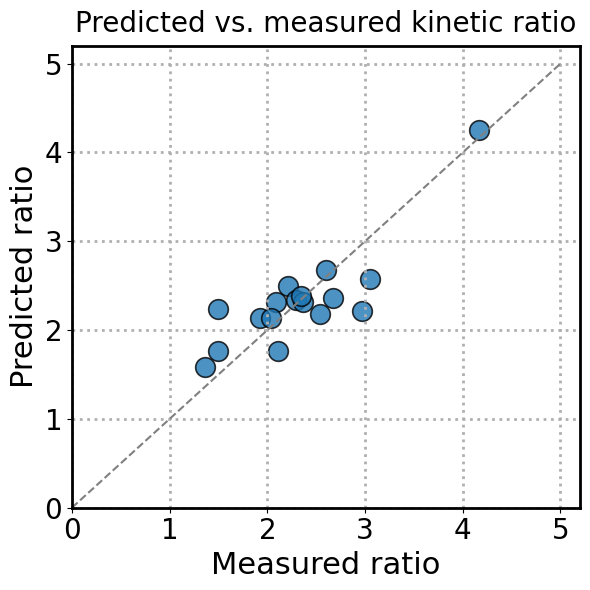

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.linewidth'] = 2  
plt.rcParams['figure.autolayout'] = False

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    y, y_pred,
    s=200,     
    alpha=0.8,
    edgecolor='k',
    linewidth=1.2
)

mn, mx = 0, 5
ax.plot([mn, mx], [mn, mx], '--', color='gray', linewidth=1.5, label="x = y")

ax.set_xlim(0, 5.2)
ax.set_ylim(0, 5.2)
ax.set_xlabel("Measured ratio", fontsize=22)
ax.set_ylabel("Predicted ratio", fontsize=22)
ax.set_title("Predicted vs. measured kinetic ratio", fontsize=20, pad=10)
ax.grid(True, linewidth=2, linestyle=':')
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.tight_layout()
plt.savefig("prediction_vs_reality_only_ratios.png", dpi=600)
plt.show()